# Building a micro grid system with a renewable share constraint
The generation of the micro grid energy system is described in yesterday's tutorial "2_tutorial_micro_grid.ipynb".

Even when adding a customized constraint to an oemof model, the initial model building is identical. To ease future programming, a logger can be used:

In [1]:
import os
import pandas as pd

from oemof.tools import logger
import logging

logger.define_logging(screen_level=logging.INFO) #screen_level=logging.DEBUG

from matplotlib import pyplot as plt

import oemof.outputlib as outputlib
import oemof.solph as solph
from oemof.tools import economics


timeindex = pd.date_range('1/1/2017', periods=8760, freq='H')

energysystem = solph.EnergySystem(timeindex=timeindex)

logging.info('Loading timeseries')
full_filename = '2_timeseries.csv'
timeseries = pd.read_csv(full_filename, sep=',')

logging.info('Defining costs')

fuel_price_kWh = 0.05 # fuel price in currency/kWh

costs = {'pp_wind': {
             'epc': economics.annuity(capex=1500, n=20, wacc=0.05)},
         'pp_pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)},
         'pp_diesel': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05),
             'var': 0},
         'storage': {
             'epc': economics.annuity(capex=300, n=5, wacc=0.05),
             'var': 0}}

print('\n')
logging.info('DEFINITION OF OEMOF MODEL:')

logging.info('Electricity bus')
bel = solph.Bus(label='electricity_bus')
energysystem.add(bel)

logging.info('Demand, fixed timeseries')
demand_sink = solph.Sink(label='demand_el',
                         inputs={bel: solph.Flow(actual_value=timeseries['demand_el'],
                                                 fixed=True,
                                                 nominal_value=500)})
energysystem.add(demand_sink)

logging.info('Excess sink')
excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
energysystem.add(excess_sink)

logging.info('Wind plant with fixed feed-in timeseries')
wind_plant = solph.Source(label='pp_wind',
                          outputs={
                              bel: solph.Flow(nominal_value=None,
                                              fixed=True,
                                              actual_value=timeseries['wind'],
                                              investment=solph.Investment(
                                                  ep_costs=costs['pp_wind']['epc']))})
energysystem.add(wind_plant)

logging.info('PV plant with fixed feed-in timeseries')
pv_plant = solph.Source(label='pp_pv',
                        outputs={
                            bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=timeseries['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pp_wind']['epc']))})

energysystem.add(pv_plant)

logging.info('Diesel fuel bus, source and transformer')
bfuel = solph.Bus(label='fuel_bus')

fuel_source = solph.Source(label='diesel',
       outputs={
           bfuel: solph.Flow(nominal_value=None,
                     variable_costs=fuel_price_kWh,
                     )}
       )

genset = solph.Transformer(label="transformer_genset",
                           inputs={bfuel: solph.Flow()},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['pp_diesel']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['pp_diesel']['epc']))},
                           conversion_factors={bel: 0.33}
                           )

energysystem.add(bfuel, fuel_source, genset)

logging.info('Battery storage')
storage = solph.components.GenericStorage(
    label='storage',
    inputs={
        bel: solph.Flow()},
    outputs={
        bel: solph.Flow()},
    loss_rate=0.00,
    initial_storage_level=0.5, # or None
    invest_relation_input_capacity=1/5,
    invest_relation_output_capacity=1,
    inflow_conversion_factor=0.95,
    outflow_conversion_factor=0.95,
    investment=solph.Investment(ep_costs=costs['storage']['epc']))

energysystem.add(storage)

print('\n')
logging.info('Initializing model')
model = solph.Model(energysystem)

model.write('./2_lp_file_micro_grid_no_constraint.lp', io_options={'symbolic_solver_labels': True})

01:57:53-INFO-Path for logging: /home/mh/.oemof/log_files/oemof.log
01:57:53-INFO-Used oemof version: 0.3.1
01:57:55-INFO-Loading timeseries
01:57:55-INFO-Defining costs


01:57:55-INFO-DEFINITION OF OEMOF MODEL:
01:57:55-INFO-Electricity bus
01:57:55-INFO-Demand, fixed timeseries
01:57:55-INFO-Excess sink
01:57:55-INFO-Wind plant with fixed feed-in timeseries
01:57:55-INFO-PV plant with fixed feed-in timeseries
01:57:55-INFO-Diesel fuel bus, source and transformer
01:57:55-INFO-Battery storage


01:57:55-INFO-Initializing model


('./2_lp_file_micro_grid_no_constraint.lp', 139852041634368)

Instead of solving the model, an own constraint can now be added. For that, a function describing the renewable share criterion has to be defined. It uses the pyomo library.

In [2]:
import pyomo.environ as po

def renewable_share_criterion(model, genset, pv_plant, wind_plant, bel, min_renewable_share):
    def renewable_share_rule(model):  
        total_renewable_generation =  sum(model.flow[pv_plant, bel, :])
        total_renewable_generation +=  sum(model.flow[wind_plant, bel, :])
        total_generation = total_renewable_generation 
        total_generation += sum(model.flow[genset, bel, :])
            
        expr = total_renewable_generation - total_generation * min_renewable_share
        return expr >= 0

    model.renewable_share_constraint = po.Constraint(rule=renewable_share_rule)

    return model

Call function renewable_share_constraint. With "po.Constraint" the constraint is added to the linear equation system generated by pyomo. Save to lp file to check constraint:

In [3]:
min_renewable_share = 0.1
renewable_share_criterion(model, genset, pv_plant, wind_plant, bel, min_renewable_share)
model.write('./2_lp_file_micro_grid_renewable_constraint.lp', io_options={'symbolic_solver_labels': True})

('./2_lp_file_micro_grid_renewable_constraint.lp', 139853065365096)

In [4]:
logging.info('Starting oemof-optimization of capacities')
model.solve(solver='cbc', solve_kwargs={'tee': False})

logging.info('Processing results')
results = outputlib.processing.results(model)

01:58:09-INFO-Starting oemof-optimization of capacities
01:58:31-INFO-Optimization successful...
01:58:31-INFO-Processing results


In [5]:
logging.info('Get optimized capacities')
el_bus = outputlib.views.node(results, 'electricity_bus')
cap_wind = el_bus['scalars'][(('pp_wind', 'electricity_bus'), 'invest')]
cap_pv = el_bus['scalars'][(('pp_pv', 'electricity_bus'), 'invest')]
cap_genset = el_bus['scalars'][(('transformer_genset', 'electricity_bus'), 'invest')]

storage_bus = outputlib.views.node(results, 'storage')
cap_storage = storage_bus['scalars'][(('storage','None'), 'invest')]

logging.info('Capacities optimized: Storage (' + str(cap_storage)
             + '), Wind (' + str(cap_wind)
             + '), PV (' + str(cap_pv)
             + '), Genset (' + str(cap_genset) + ').')

01:58:32-INFO-Get optimized capacities
01:58:32-INFO-Capacities optimized: Storage (0.0), Wind (1047.2029), PV (203.30226), Genset (444.41607).


01:58:32-INFO-Plot flows on electricity bus


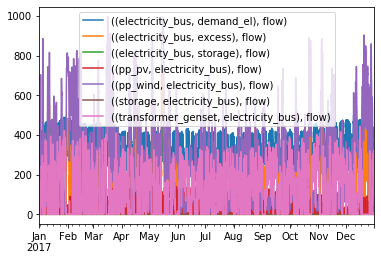

In [6]:
logging.info('Plot flows on electricity bus')
outputlib.views.node(results, 'electricity_bus')['sequences'].plot(drawstyle='steps')

Check whether constraint is fullfilled by calculating renewable share:

In [7]:
renewable_generation = sum(el_bus['sequences'][(('pp_wind', 'electricity_bus'), 'flow')])
renewable_generation += sum(el_bus['sequences'][(('pp_pv', 'electricity_bus'), 'flow')]) 
total_generation = renewable_generation + sum(el_bus['sequences'][(('transformer_genset', 'electricity_bus'), 'flow')]) 

renewable_share = renewable_generation/total_generation

if  renewable_share >= min_renewable_share:
    print('Constraint fullfilled, renewable share at ' + str(round(renewable_share*100, 1)) + '%.')
else:
    print('Constraint failed, renewable share at ' + str(round(renewable_share*100, 1)) + '%.')
            
        

Constraint fullfilled, renewable share at 70.5%.


In [8]:
el_bus['sequences'].sum(axis=0)

((electricity_bus, demand_el), flow)             2.989218e+06
((electricity_bus, excess), flow)                5.812174e+05
((electricity_bus, storage), flow)               0.000000e+00
((pp_pv, electricity_bus), flow)                 2.390734e+05
((pp_wind, electricity_bus), flow)               2.279432e+06
((storage, electricity_bus), flow)               0.000000e+00
((transformer_genset, electricity_bus), flow)    1.051930e+06
dtype: float64